<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/torchvision_object_detection_and_Instance_Segmentation_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# torchvision 객체 검출 미세조정(fine tunning)
reference : https://tutorials.pytorch.kr/intermediate/torchvision_tutorial.html#id8

* Dataset : Penn-Fudan Database for Pedestrian Detection and Segmentation (https://www.cis.upenn.edu/~jshi/ped_html/)

* Detection Model : Pre-trained Mask R-CNN

# 데이터셋 정의하기

* 새로운 사용자 정의 데이터셋을 추가
* 데이터셋은 표준 torch.utils.data.Dataset 클래스를 상속받으며 __len__와 __getitem__ 메소드를 구현해야한다.

## getitem 메소드의 반환값
* 이미지 : PIL(Python Image Library) 이미지의 크기 (H, W)
* target : 다음 key값들을 포함하는 dictionary 타입
           - boxes(FloatTensor[N, 4]) : N개의 바운딩 박스 좌표를 [x0, y0, x1, y1] 형태로 가짐, x범위는 [0, W], y범위는 [0, H]
           - labels(Int64Tensor[N]) : 바운딩 박스마다 label정보, 0은 항상 배경을 의미
           - area(Tensor[N]) : 바운딩 박스의 면적. 작음, 중간, 큰 박스간의 점수를 내기위한 기준이며 COCO평가를 기준으로 함.
           - iscrowd(UInt8Tensor[N]) : 이 값이 참일 경우 평가에서 제외
           -(선택적)masks(UInt8Tensor[N, H, W]) : N개의 객체마다 분할마스크 정보
           -(선택적)keypoints(FloatTensor[N, K, 3]) : N개의 객체마다 키포인트 정보. 키포인트는 [x, y, visibility]형태를 가진다. visibility 값이 0인 경우 키포인트가 보이지 않음을 의미

labels에 대한 참고사항 : 이 모델은 클래스 0 을 배경으로 취급한다. 만약 준비한 데이터셋에 배경 클래스가 없다면 labels에도 0이 없어야함. 예를 들어, 어떤 이미지에 전체 두개의 클래스에 두개의 클래스가 모두 있다면 labels 텐서는 [1, 2]와 같은 식이 되어야함.

# 커스텀 데이터셋 클래스 작성

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

PennFudanPed 데이터셋 구조
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

image 및 세그멘테이션 마스크 출력

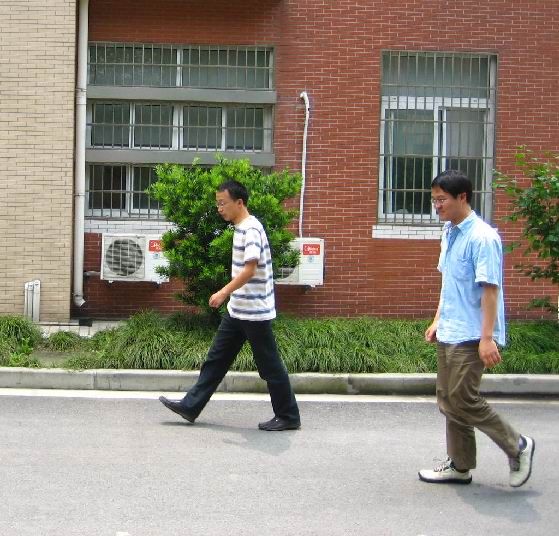

In [2]:
from PIL import Image
Image.open('/content/PennFudanPed/PNGImages/FudanPed00001.png')

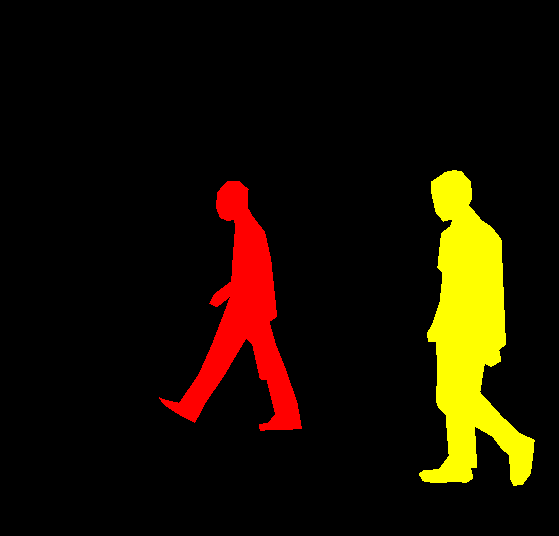

In [3]:
mask = Image.open('/content/PennFudanPed/PedMasks/FudanPed00001_mask.png')

# 각 마스크 인스턴스는 0부터 N까지 다른컬러를 가지고 있음
# N은 객체 수 이며 시각화를 돕기위해 color palette에 마스크를 추가한다.
mask.putpalette([
                 0, 0, 0, # black background
                 255, 0, 0, # index 1은 red
                 255, 255, 0, # index 2는 yellow
                 255, 153, 0, # index 3은 orange
])
mask

In [4]:
import numpy as np
mask = Image.open('/content/PennFudanPed/PedMasks/FudanPed00004_mask.png')
mask = np.array(mask)

In [5]:
mask.shape

(397, 396)

In [6]:
len(mask[mask == 0]), len(mask[mask == 1]), len(mask[mask == 2])

(140081, 15058, 2073)

In [7]:
np.unique(mask)[1:]

array([1, 2], dtype=uint8)

In [8]:
np.unique(mask)[1:].shape, np.unique(mask)[1:][:, None].shape, np.unique(mask)[1:][:, None, None].shape

((2,), (2, 1), (2, 1, 1))

In [9]:
masks = (mask == np.unique(mask)[1:][:, None, None])
masks.shape

(2, 397, 396)

In [10]:
np.where(masks[0])

(array([ 59,  59,  59, ..., 337, 337, 337]),
 array([236, 237, 238, ..., 203, 204, 205]))

In [11]:
boxes = []
for i in range(2):
  pos = np.where(masks[i])
  xmin = np.min(pos[1])
  xmax = np.max(pos[1])
  ymin = np.min(pos[0])
  ymax = np.max(pos[0])
  boxes.append([xmin, ymin, xmax, ymax])

In [12]:
boxes

[[167, 59, 323, 337], [8, 60, 47, 179]]

In [15]:
boxes = torch.as_tensor(boxes, dtype=torch.float32)
print(boxes)
print((boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]))

tensor([[167.,  59., 323., 337.],
        [  8.,  60.,  47., 179.]])
tensor([43368.,  4641.])


In [54]:
import os
import numpy as np
import torch
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms = None):
    self.root = root
    self.transforms = transforms
    # 모든 이미지 파일들을 읽고 정렬
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
  
  def __getitem__(self, idx):
    # 이미지와 마스크를 읽어온다.
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = Image.open(img_path).convert("RGB")

    # segmentation mask의 각 색상은 다른 인스턴스를 나타내고 0은 배경을 나타나므로 RGB로 변환하지않는다
    mask = Image.open(mask_path)
    # PIL 이미지를 numpy배열로 변환
    mask = np.array(mask)
    # 인스턴스들은 다른색들로 인코딩되어 있음
    obj_ids = np.unique(mask)
    # 첫번째 id는 배경이므로 제거
    obj_ids = obj_ids[1:]

    # 컬러 인코딩된 마스크를 바이너리 마스크 세트로 나눈다
    # [객체수 , w, h], 각 객체에 대한 mask정보를 True, False로 저장
    masks = mask == obj_ids[:, None, None]

    # 각 마스크의 바운딩 박스 좌표를 얻는다.
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      # i번째 인스턴스가 True인 좌표를 구함
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])
    
    # 모든 것을 torch.Tensor타입으로 변환
    boxes = torch.as_tensor(boxes, dtype = torch.float32)
    # 객체 종류는 보행자만 검출하므로 1개만 존재
    labels = torch.ones((num_objs,), dtype = torch.int64)
    masks = torch.as_tensor(masks, dtype = torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # 모든 인스턴스는 crowd가 False임을 가정
    iscrowd = torch.zeros((num_objs,), dtype = torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)
    
    return img, target

  def __len__(self):
    return len(self.imgs)
  

In [16]:
dataset = PennFudanDataset("PennFudanPed/")
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FCE9FF372D0>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1., 1.]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

# 모델 정의하기
* Faster R-CNN : 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델

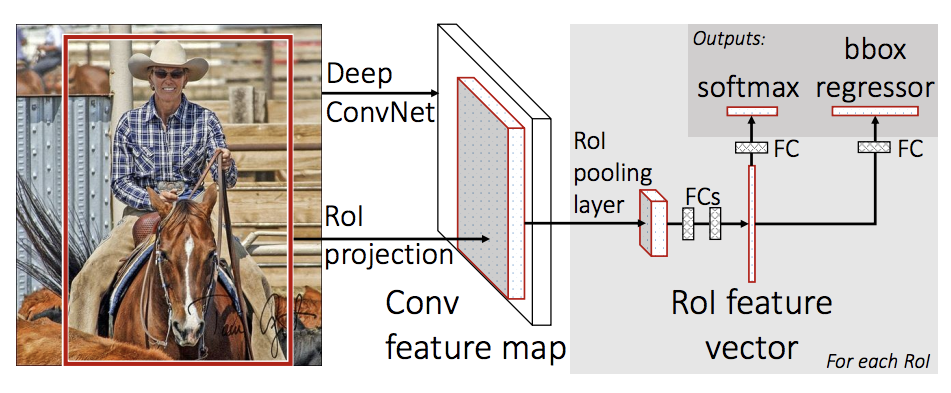

* Mask R-CNN : 각 인스턴스에 대한 Segmentation 마스크를 예측하는 추가 레이어를 Faster R-CNN에 추가한 모델

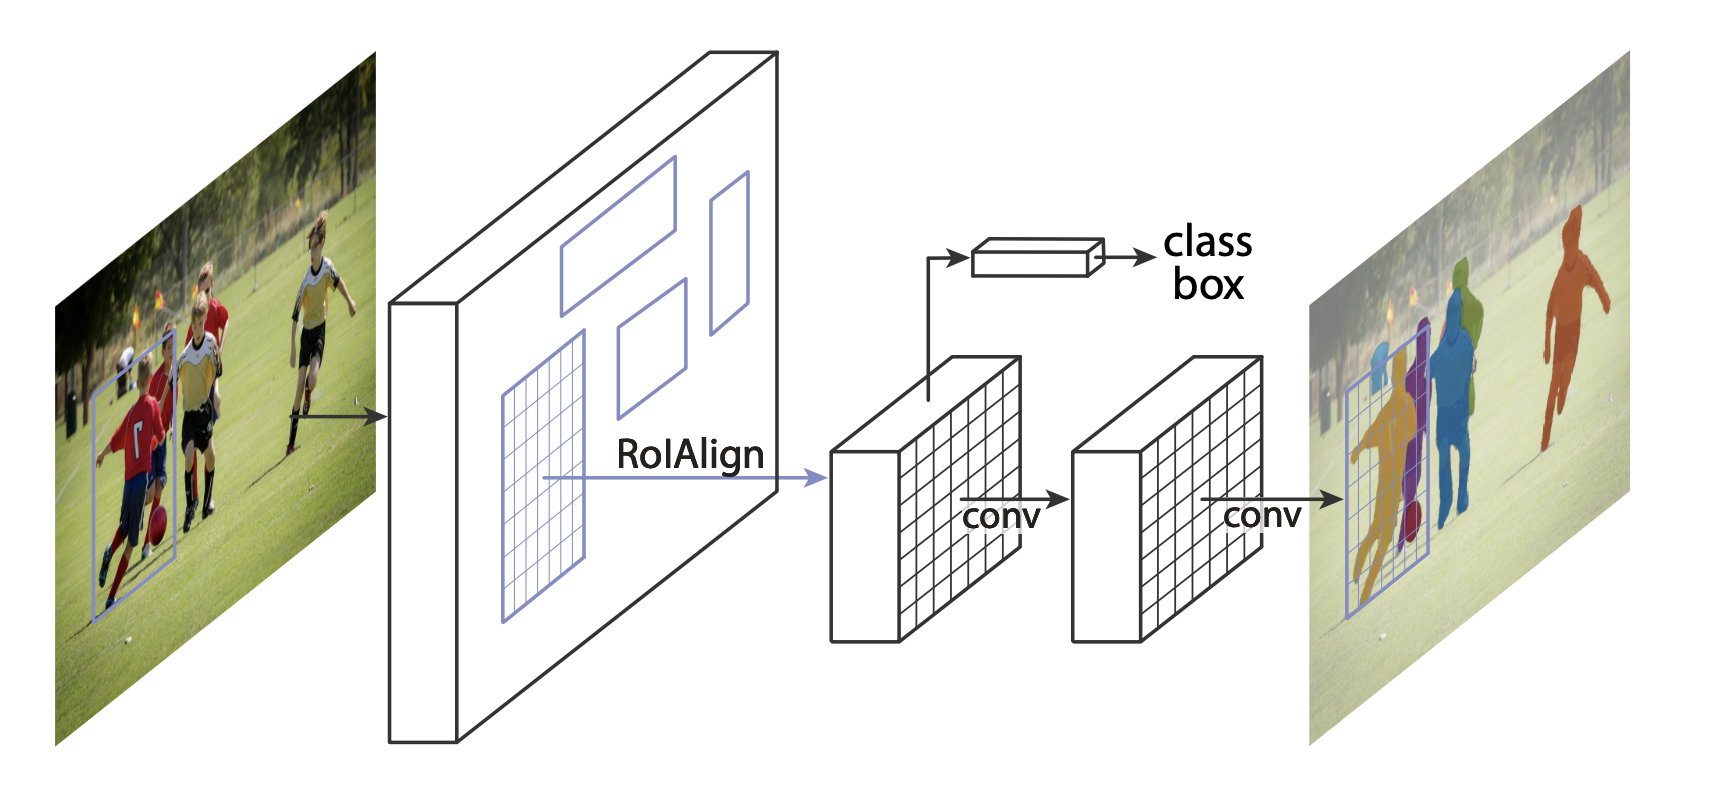

## - 미리 학습된 모델로부터 미세조정 (Finetunining from a pretrained model)

COCO dataset에 대해 pretrained된 모델에서 시작하여 특정 클래스를 위해 미세조정

In [29]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# COCO로 사전 학습된 모델 읽기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
print(model.roi_heads.box_predictor)

# classifier를 새로운 것으로 교체, num_classes는 사용자가 정의
num_classes = 2 # 사람 + 배경이므로 클래스 갯수는 2개

# classifier에서 사용할 입력 특징의 차원정보를 얻음
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 미리 학습된 모델의 head 부분을 새로운 것으로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


## - 다른 백본을 추가하도록 모델을 수정하기

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 분류 목적으로 미리 학습된 모델을 로드하고 특징들 만을 리턴하도록 한다.
backbone = torchvision.models.mobilenet_v2(pretrained = True).features
backbone

In [34]:
# Faster RCNN은 백본의 출력 채널 수를 알아야함
# mobilenetV2의 경우 1280이므로 추가해준다.
backbone.out_channels = 1280

# RPN(Region Proposal Network)이 5개의 서로다른 크기와 3개의 다른 Aspect ratio를 가지는
# 5 x 3개의 앵커를 spatial location마다 생성하도록 만든다.
# 각 feature map이 잠재적으로 다른 사이즈와 aspect ratio를 가질 수 있기 때문에 Tuple[Tuple[int]] 타입을 가지도록 한다.

anchor_generator = AnchorGenerator(sizes = ((32, 64, 128, 256, 512),),
                                   aspect_ratios =((0.5, 1.0, 2.0)))

# rescaling후의 crop size와 RoI cropping을 수행할 feature map을 정의한다
# 만약 백본이 텐서를 리턴할때, featmap_names는 [0]이 될것이다.
# 일반적으로 백본은 OrderedDict[Tensor] 타입을 리턴해야 한다.
# 그리고 featmap_nmaes에서 어느 feature map을 사용할지 정할 수 있다.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names = ['0'],
                                                output_size = 7,
                                                sampling_ratio = 2)

# Faster RCNN모델로 합친다.
model = FasterRCNN(backbone,
                   num_classes = 2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool= roi_pooler)

# PennFudan 데이터셋을 위한 Instance Segmentation 모델

* 데이터셋이 매우 작기 때문에 미리 학습된 모델에서 미세 조정하는 방식으로 진행

* Instance Segmentation mask도 계산하기 위해 Mask R-CNN 사용

In [39]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
  # COCO에서 사전 학습된 Instance Segmentaion 모델을 읽어옴
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)

  # classifier를 위한 input feature의 크기를 얻는다.
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # 사전학습된 모델의 head를 새로운 head로 교체한다.
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # mask classifier를 위해 input feature의 수를 구한다.
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # mask predictor를 새로운 predictor로 교체한다.
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                     hidden_layer,
                                                     num_classes)
  
  return model

##detection 모델의 학습과 평가를 위한 helper function 복사

In [40]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 106985, done.
remote: Counting objects: 100% (42116/42116), done.
remote: Compressing objects: 100% (3398/3398), done.
remote: Total 106985 (delta 38974), reused 41347 (delta 38503), pack-reused 64869
Receiving objects: 100% (106985/106985), 209.29 MiB | 7.91 MiB/s, done.
Resolving deltas: 100% (92049/92049), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


# 데이터 증강 / 변환을 위한 helper function

In [41]:
import transforms as T

def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    # 학습시 50% 확률로 학습 영상을 좌우 반전 변환
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

# forward() 메소드 테스트
데이터셋을 학습시키기 전에, 샘플데이터로 학습과 추론시 모델이 예상대로 동작하는지 테스트

In [57]:
import warnings
warnings.filterwarnings(action='ignore') 

In [58]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train = True))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size = 2, shuffle = True, num_workers = 4,
    collate_fn = utils.collate_fn
)

### 학습인 경우

In [59]:
images, target = next(iter(data_loader))

In [60]:
# 튜플이 아닌 리스트에 배치 데이터를 담는다.
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in target]

In [61]:
# losses 와 detection 결과를 반환
output = model(images, targets)

In [62]:
output

{'loss_box_reg': tensor(0.0331, grad_fn=<DivBackward0>),
 'loss_classifier': tensor(0.1061, grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(0.0149, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0010, grad_fn=<DivBackward0>)}

### 추론인 경우

* Mask R-CNN 모델에 의해 내부적으로 처리되기 때문에 데이버 증강/변환에 mean/std normalization 또는 이미지 rescaling를 추가할 필요 없음



In [63]:
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [64]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

# dataset class, model, data transforms를 인스턴트화 하고 합치기

In [80]:
# 데이터셋 정의
dataset =PennFudanDataset('PennFudanPed', get_transform(train = True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train = False))

In [81]:
# 전체 학습데이터의 50개를 테스트에 사용한다.
torch.manual_seed(1)
# 0 ~ len(dataset) 랜덤 순열
indices = torch.randperm(len(dataset)).tolist()

In [82]:
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [84]:
# 학습과 검증용 데이터 로더를 정의
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size = 2, shuffle = True, num_workers = 4,
    collate_fn = utils.collate_fn
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size = 1, shuffle = False, num_workers = 4,
    collate_fn = utils.collate_fn
)

In [85]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 클래스 : 사람, 배경 2개
num_classes = 2

# 함수를 사용해 모델 초기화
model = get_model_instance_segmentation(num_classes)
model.to(device)

# optimizer 생성
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005,
                            momentum = 0.9, weight_decay = 0.0005)

# 3 epoch마다 학습률을 10배 감소시키는 learning rate scheduler 정의
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size = 3,
                                               gamma = 0.1)

# 10번 학습하고 매 epoch 종료시 evaluating 수행

In [86]:
from torch.optim.lr_scheduler import StepLR
from engine import train_one_epoch, evaluate

num_epochs = 10

for epoch in range(num_epochs):
  # 한 epoch학습하고 10회씩 순회할때마다 결과 출력
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq = 10)
  # learning rate 업데이트
  lr_scheduler.step()
  # 테스트 데이터에 대해 평가
  evaluate(model, data_loader_test, device = device)

Epoch: [0]  [ 0/60]  eta: 0:01:02  lr: 0.000090  loss: 2.8002 (2.8002)  loss_classifier: 0.7481 (0.7481)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0454 (0.0454)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 1.0422  data: 0.6247  max mem: 3879
Epoch: [0]  [10/60]  eta: 0:00:20  lr: 0.000936  loss: 1.3692 (1.7225)  loss_classifier: 0.5193 (0.4831)  loss_box_reg: 0.2959 (0.2980)  loss_mask: 0.7142 (0.9196)  loss_objectness: 0.0110 (0.0169)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.4165  data: 0.0629  max mem: 3879
Epoch: [0]  [20/60]  eta: 0:00:15  lr: 0.001783  loss: 0.9809 (1.2276)  loss_classifier: 0.2184 (0.3355)  loss_box_reg: 0.2865 (0.2861)  loss_mask: 0.3229 (0.5876)  loss_objectness: 0.0086 (0.0138)  loss_rpn_box_reg: 0.0041 (0.0045)  time: 0.3424  data: 0.0075  max mem: 3879
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 0.5566 (1.0152)  loss_classifier: 0.0954 (0.2557)  loss_box_reg: 0.2732 (0.2875)  loss_mask: 0.1791 (0.4541)  loss_ob

1 epoch 학습시
* COCO style mAP : 66.1
* mask mAP : 71.3

10 epoch 학습시
* COCO style mAP : 84.1
* mask mAP : 75.8

# Test image Inference

In [89]:
# 테스트 이미지 샘플 선택
img, _ = dataset_test[0]

# model을 evaluation mode로 설정
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

In [90]:
# 입력이미지 갯수만큼 딕셔너리 리스트를 반환
# 각 딕셔너리는 바운딩 박스, label, mask정보, score를 키값으로 가지고 있음
prediction

[{'boxes': tensor([[ 62.0381,  36.6596, 198.4036, 327.5063],
          [276.5634,  23.4207, 290.9023,  73.6241]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9986, 0.6543], device='cuda:0')}]

In [98]:
img.permute(1,2,0).shape

torch.Size([349, 292, 3])

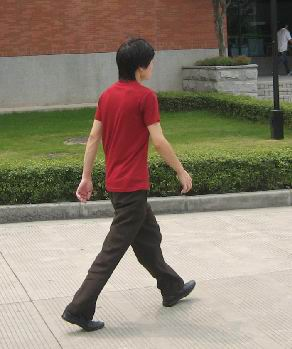

In [99]:
# 이미지 픽셀값이 0~1 사이값으로 rescaling 되어 있기때문에 255를 곱해주고
# 채널을 섞어서 [C, H, W]에서 [H, W, C] format으로 변환
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

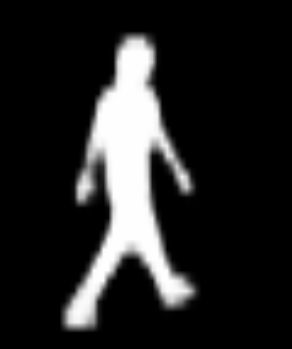

In [104]:
# segmentation mask 시각화
# 마스크는 [N, 1, H, W] 구조, N은 예측된 객체 수
# 0~1 사이값으로 rescaling 되어있으므로 255를 곱해줌
Image.fromarray(prediction[0]['masks'][0,0].mul(255).byte().cpu().numpy())

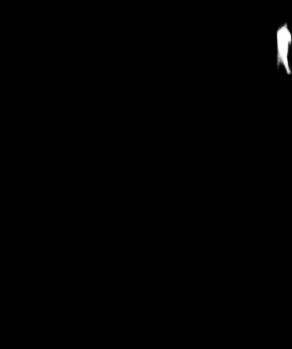

In [106]:
Image.fromarray(prediction[0]['masks'][1,0].mul(255).byte().cpu().numpy())

In [134]:
prediction[0]['masks'].size()[0]

2

In [130]:
#masked_bool = prediction[0]['masks'][0,0].mul(255).byte().cpu().numpy().astype(bool)
mask = prediction[0]['masks'][0,0].mul(255).byte().cpu().numpy()
masked_bool = mask >= 120
print('masked_bool shape:', masked_bool.shape)
print(masked_bool[masked_bool==1].shape, masked_bool[masked_bool==0].shape)
print(masked_bool[masked_bool==1])

masked_bool shape: (349, 292)
(15080,) (86828,)
[ True  True  True ...  True  True  True]


In [112]:
# mask 값에 따라 channel 별로 alpha값을 감안하여 색상 적용
def apply_mask_01(image, mask, color, alpha=0.5):
  for c in range(3):
    image[:, :, c] = np.where(mask == 1,
                              image[:, :, c] *
                              (1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
  return image

(-0.5, 291.5, 348.5, -0.5)

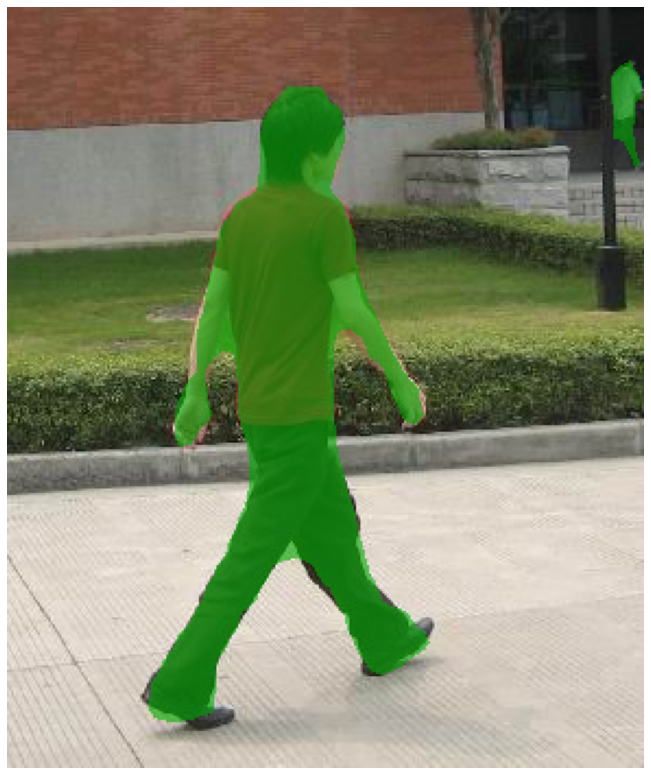

In [135]:
import matplotlib.pyplot as plt
img = img.mul(255).permute(1, 2, 0).byte().numpy()
draw_img = img.copy()

for i in range(prediction[0]['masks'].size()[0]):
  mask = prediction[0]['masks'][i,0].mul(255).byte().cpu().numpy()
  masked_bool = mask >= 120
  # masking 정보는 2차원 bool array로 전달. 
  draw_img = apply_mask_01(draw_img, masked_bool, (0, 255, 0), alpha=0.6)

plt.figure(figsize=(12, 14))
plt.imshow(draw_img)
plt.axis('off')